In [178]:
import math

import arviz as az
import daft
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax.numpy as jnp
from jax import lax, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro import handlers
from numpyro.diagnostics import print_summary, hpdi
from numpyro.infer import ELBO, SVI, Predictive, NUTS, MCMC
from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

import seaborn as sns

5m3

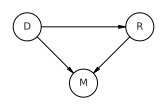

In [3]:
dag5m3 = CausalGraphicalModel(
    nodes=["D", "M", "R"], edges=[("D", "M"), ("R", "M"), ("D", "R")]
)
pgm = daft.PGM()
coordinates = {"D": (0, 0), "M": (1, 1), "R": (2, 0)}
for node in dag5m3.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5m3.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

In [54]:
N = 100
div = dist.Normal().sample(random.PRNGKey(0), sample_shape=(N,))
rem = dist.Normal(.55 * div).sample(random.PRNGKey(1))
mar = dist.Normal(1.1 + 0.2 * div + 0.4 * rem).sample(random.PRNGKey(2))

df_rev = pd.DataFrame(zip(div, rem, mar), columns=["div", 'rem', 'mar'])
df_rev.sample(3)

,div,rem,mar
73,0.278623,1.030700,1.392383
52,1.697748,0.563920,3.174329
12,0.987387,-0.503119,-0.265333


/Users/urosrapajic/work/rethinking-numpyro/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:1342: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(pad=layout_pad)


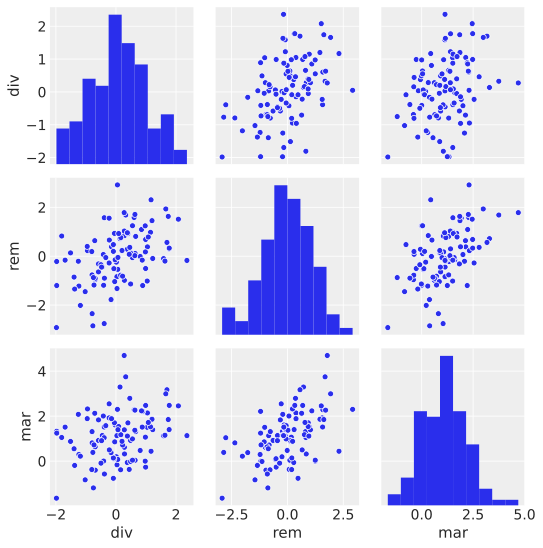

In [55]:
sns.pairplot(df_rev)

In [61]:
def model(mar, div=None, rem=None):
    a = numpyro.sample('a', dist.Normal())
    D, R = 0, 0
    if div is not None:
        bD = numpyro.sample('bD', dist.Normal())
        D = bD * div
    if rem is not None:
        bR = numpyro.sample('bR', dist.Normal())
        R = bR * rem
    mu = a + D + R
    sigma = numpyro.sample('sigma', dist.Uniform(0,2))
    numpyro.sample('mar', dist.Normal(mu, sigma), obs=mar)

In [62]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, mar=df_rev['mar'].values, div=df_rev['div'].values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()


sample: 100%|██████████| 3000/3000 [00:09<00:00, 332.63it/s, 3 steps of size 7.97e-01. acc. prob=0.90]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.07      0.11      1.07      0.90      1.24   1873.19      1.00
        bD      0.35      0.11      0.36      0.17      0.54   1738.69      1.00
     sigma      1.05      0.08      1.04      0.93      1.17   1825.44      1.00

Number of divergences: 0


In [63]:
rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)

mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, mar=df_rev['mar'].values, rem=df_rev['rem'].values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:09<00:00, 320.22it/s, 7 steps of size 6.91e-01. acc. prob=0.94]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.10      0.10      1.10      0.95      1.25   1882.94      1.00
        bR      0.52      0.08      0.52      0.39      0.65   1508.07      1.00
     sigma      0.94      0.07      0.93      0.82      1.04   1840.83      1.00

Number of divergences: 0


In [64]:
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, mar=df_rev['mar'].values, div=df_rev['div'].values, rem=df_rev['rem'].values)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:10<00:00, 296.26it/s, 7 steps of size 7.13e-01. acc. prob=0.90]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.09      0.09      1.09      0.94      1.25   2051.37      1.00
        bD      0.10      0.11      0.10     -0.07      0.28   1994.51      1.00
        bR      0.48      0.09      0.48      0.33      0.63   1864.08      1.00
     sigma      0.94      0.07      0.93      0.82      1.04   1480.02      1.00

Number of divergences: 0


5m4

In [70]:
waffle_divorce = pd.read_csv('../data/WaffleDivorce.csv', sep=';')
waffle_divorce.sample(3)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
23,Minnesota,MN,5.30,26.3,15.3,0.77,7.4,0.60,0,0,0,172023,0.0
22,Michigan,MI,9.88,26.4,16.5,0.69,9.2,0.53,0,0,0,749113,0.0
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.0


In [72]:
d = waffle_divorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [87]:
LDS = [0.0077, 0.0453, 0.0610, 0.0104, 0.0194, 0.0270, 0.0044, 0.0057, 0.0041, 0.0075, 0.0082, 0.0520, 0.2623, 0.0045, 0.0067, 0.0090, 0.0130, 0.0079, 0.0064, 0.0082, 0.0072, 0.0040, 0.0045, 0.0059, 0.0073, 0.0116, 0.0480, 0.0130, 0.0065, 0.0037, 0.0333, 0.0041, 0.0084, 0.0149, 0.0053, 0.0122, 0.0372, 0.0040, 0.0039, 0.0081, 0.0122, 0.0076, 0.0125, 0.6739, 0.0074, 0.0113, 0.0390, 0.0093, 0.0046, 0.1161]

d["LDS"] = LDS
d["logLDS"] = d["LDS"].apply(math.log)
d["logNormLDS"] = (d["logLDS"] - d["logLDS"].mean()) / d["logLDS"].std()

<AxesSubplot:>

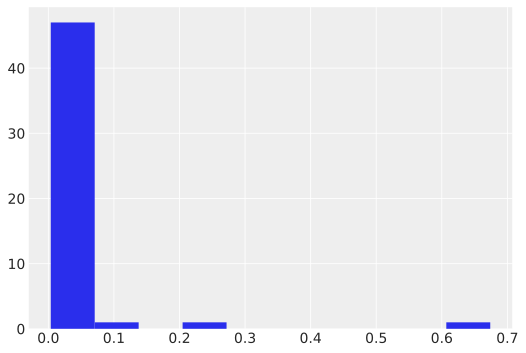

In [85]:
d["LDS"].hist()

<AxesSubplot:>

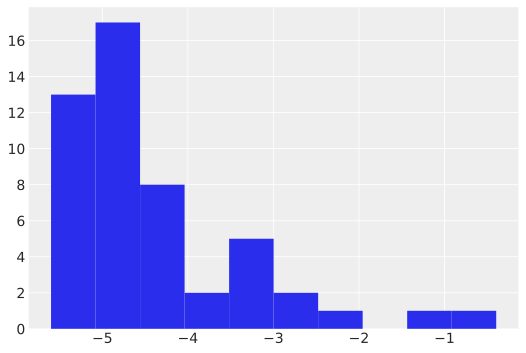

In [86]:
d["logLDS"].hist()

<AxesSubplot:>

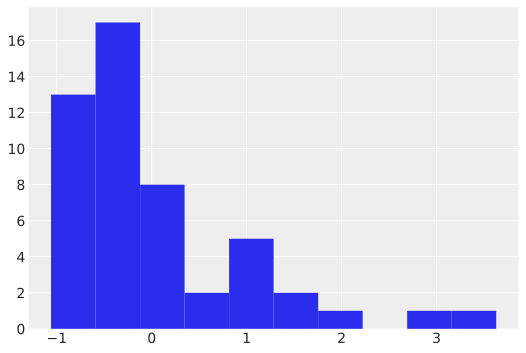

In [88]:
d["logNormLDS"].hist()

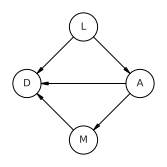

In [100]:
dag5m4 = CausalGraphicalModel(
    nodes=["D", "M", "A", "L"],
    edges=[("M", "D"), ("A", "D"), ("A", "M"), ("L", "D"), ("L", "A")]
)
pgm = daft.PGM()
coordinates = {"D": (0, 0), "M": (1, 1), "A": (2, 0), "L": (1, -1)}
for node in dag5m4.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5m4.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

In [95]:
def model(div, age, mar, lds):
    a = numpyro.sample('a', dist.Normal(10, 20))
    bM = numpyro.sample('bM', dist.Normal(0, 10))
    bA = numpyro.sample('bA', dist.Normal(0, 10))
    bL = numpyro.sample('bL', dist.Normal(0, 10))
    mu = a + bM * mar + bA * age + bL * lds
    sigma = numpyro.sample('sigma', dist.Uniform(0,5))
    numpyro.sample('div', dist.Normal(mu, sigma), obs=div)

In [96]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, div=d['D'].values, mar=d['M'].values, age=d['A'].values, lds=d["logNormLDS"].values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:10<00:00, 287.32it/s, 7 steps of size 3.92e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.12     -0.01     -0.21      0.19   1972.02      1.00
        bA     -0.77      0.17     -0.77     -1.04     -0.47   1230.21      1.00
        bL     -0.34      0.17     -0.35     -0.63     -0.06   1316.47      1.00
        bM      0.06      0.20      0.06     -0.22      0.40   1104.28      1.00
     sigma      0.81      0.09      0.80      0.68      0.95   1507.67      1.00

Number of divergences: 0


In [99]:
def model(age, lds):
    a = numpyro.sample('a', dist.Normal(10, 20))
    bL = numpyro.sample('bL', dist.Normal(0, 10))
    mu = a + bL * lds
    sigma = numpyro.sample('sigma', dist.Uniform(0,5))
    numpyro.sample('age', dist.Normal(mu, sigma), obs=age)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, age=d['A'].values, lds=d["logNormLDS"].values)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:09<00:00, 317.54it/s, 7 steps of size 8.18e-01. acc. prob=0.90]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.00     -0.19      0.18   2049.83      1.00
        bL     -0.64      0.12     -0.64     -0.83     -0.45   1864.73      1.00
     sigma      0.80      0.09      0.79      0.65      0.93   1820.58      1.00

Number of divergences: 0


5h1

In [102]:
foxes = pd.read_csv(
    "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv", sep=";"
)
foxes.sample(3)

,group,avgfood,groupsize,area,weight
25,10,0.65,3,1.73,1.92
39,13,0.60,4,3.02,2.35
33,12,0.98,7,3.84,2.99


In [107]:
foxes.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


/Users/urosrapajic/work/rethinking-numpyro/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:1342: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(pad=layout_pad)


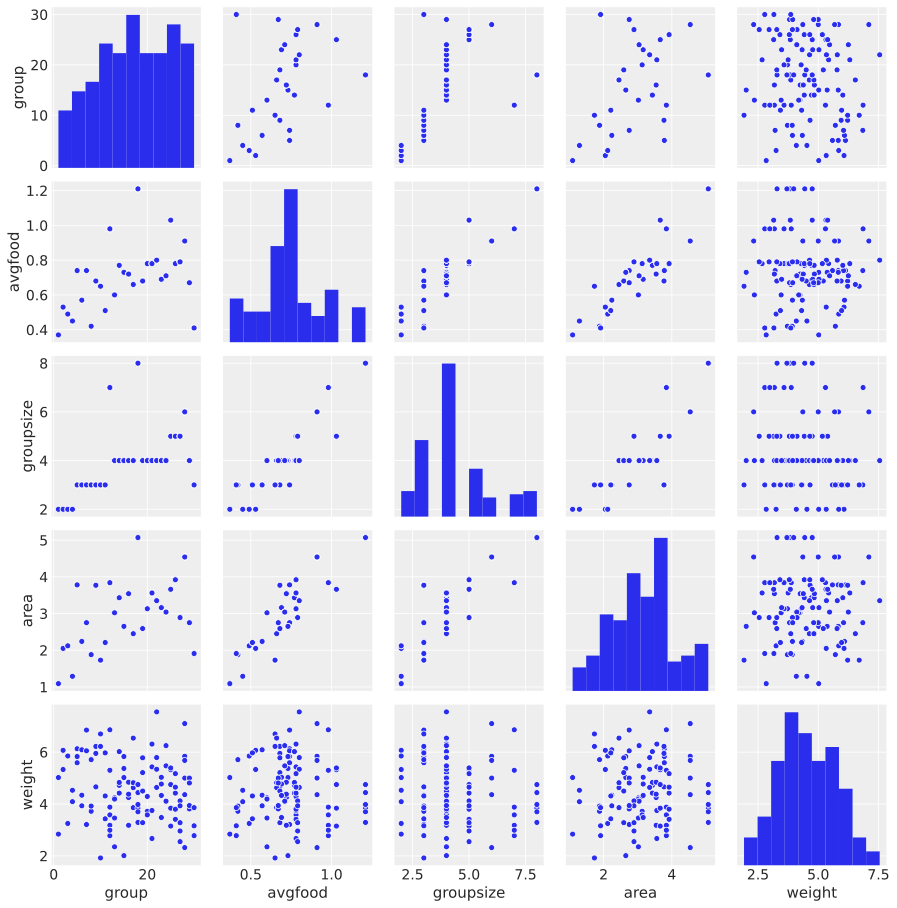

In [104]:
sns.pairplot(foxes)

In [116]:
def plot_prior_predictive(N, fn, xlim, ylim, xlabel='x', ylabel='y'):
    plt.subplot(
        xlim=xlim,
        ylim=ylim,
        xlabel=xlabel,
        ylabel=ylabel,
    )
    plt.axhline(y=1, c="k", ls="--")
    plt.axhline(y=8, c="k", ls="-", lw=0.5)
    plt.title("prior predictive distribution")
    x = jnp.linspace(*xlim, 101)
    for i in range(N):
        plt.plot(x, fn(x,i), "k", alpha=0.2)
    plt.show()

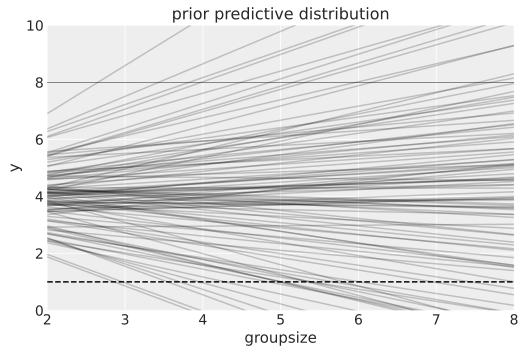

In [125]:
with handlers.seed(rng_seed=333):
    N = 100  # 100 lines
    a = numpyro.sample('a', dist.Normal(4,0.5).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 0.5).expand([N]))

plot_prior_predictive(N,
    lambda x, i: a[i] + b[i] * x,
    (foxes.groupsize.min(), foxes.groupsize.max()),
    (0,10),
    xlabel="groupsize"
)

In [196]:
def model(weight, territory=None, group=None, food=None):
    a = numpyro.sample('a', dist.Normal(4,0.5))
    T, G, F = 0, 0, 0
    if territory is not None:
        bT = numpyro.sample("bT", dist.Normal(0, 5))
        T = bT * territory
    if group is not None:
        bG = numpyro.sample("bG", dist.Normal(0, 5))
        G = bG * group
    if food is not None:
        bF = numpyro.sample("bF", dist.Normal(0, 5))
        F = bF * food
    mu = a + T + G + F
    sigma = numpyro.sample('sigma', dist.Uniform(0,5))
    numpyro.sample('weight', dist.Normal(mu, sigma), obs=weight)

kernel = NUTS(model)

In [197]:
mcmc_weight_terr = MCMC(kernel, num_warmup, num_samples)
mcmc_weight_terr.run(rng_key_, weight=foxes.weight.values, territory=foxes.area.values)
mcmc_weight_terr.print_summary()
post_samples_territory = mcmc_weight_terr.get_samples()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 340.68it/s, 15 steps of size 2.32e-01. acc. prob=0.95]
                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      4.28      0.33      4.28      3.72      4.78    741.41      1.00
        bT      0.07      0.10      0.08     -0.08      0.24    736.36      1.00
     sigma      1.20      0.08      1.20      1.08      1.32   1017.11      1.00

Number of divergences: 0



In [198]:
mcmc_weight_group = MCMC(kernel, num_warmup, num_samples)
mcmc_weight_group.run(rng_key_, weight=foxes.weight.values, group=foxes.groupsize.values)
mcmc_weight_group.print_summary()
post_samples_group = mcmc_weight_group.get_samples()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 337.78it/s, 15 steps of size 2.61e-01. acc. prob=0.94]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      4.74      0.27      4.75      4.26      5.14    719.77      1.00
        bG     -0.06      0.06     -0.06     -0.16      0.04    727.38      1.00
     sigma      1.19      0.08      1.18      1.06      1.32    955.69      1.00

Number of divergences: 0


In [199]:
def plot_regression(x, y, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    x_sorted = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    y_sorted = y[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(x_sorted, mean)
    ax.plot(x_sorted, y_sorted, 'o')
    ax.fill_between(x_sorted, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

[Text(0.5, 0, 'area'), Text(0, 0.5, 'weight'), Text(0.5, 1.0, '')]

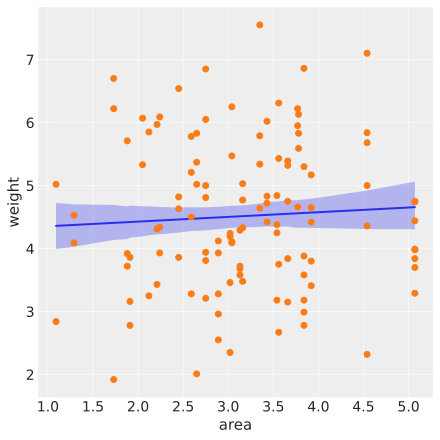

In [200]:
# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(post_samples_territory['a'], -1) + \
               jnp.expand_dims(post_samples_territory['bT'], -1) * foxes.area.values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(
    foxes.area.values,
    foxes.weight.values,
    mean_mu,
    hpdi_mu
)
ax.set(xlabel='area', ylabel='weight', title='')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Regression line with 90% CI')]

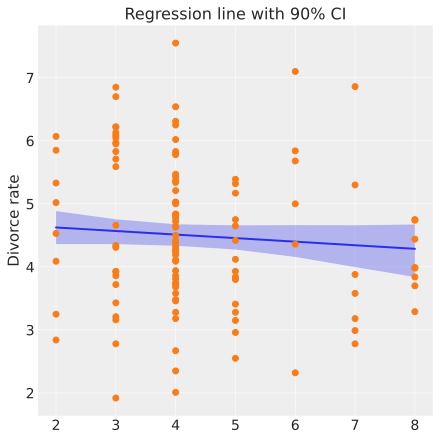

In [201]:
# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(post_samples_group['a'], -1) + \
               jnp.expand_dims(post_samples_group['bG'], -1) * foxes.groupsize.values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(
    foxes.groupsize.values,
    foxes.weight.values,
    mean_mu,
    hpdi_mu
)
ax.set(xlabel='', ylabel='Divorce rate', title='Regression line with 90% CI')

### 5h2

In [202]:
mcmc_5h2 = MCMC(kernel, num_warmup, num_samples)
mcmc_5h2.run(rng_key_, weight=foxes.weight.values, territory=foxes.area.values, group=foxes.groupsize.values)
mcmc_5h2.print_summary()
post_samples_5h2 = mcmc_5h2.get_samples()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 336.01it/s, 31 steps of size 1.36e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      4.31      0.30      4.31      3.81      4.80   1145.06      1.00
        bG     -0.42      0.12     -0.42     -0.63     -0.24   1119.83      1.00
        bT      0.65      0.19      0.65      0.35      0.96   1056.10      1.00
     sigma      1.14      0.07      1.14      1.02      1.26   1177.87      1.00

Number of divergences: 0


[Text(0.5, 0, 'area'), Text(0, 0.5, 'weight'), Text(0.5, 1.0, '')]

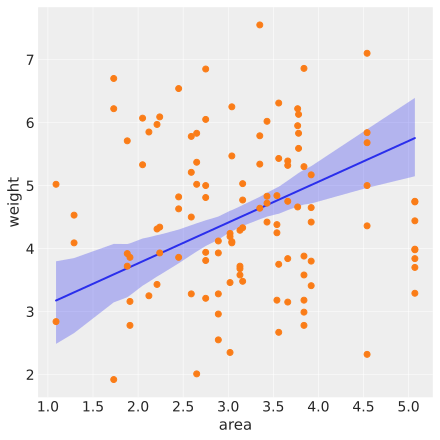

In [203]:
posterior_mu = jnp.expand_dims(post_samples_5h2['a'], -1) + \
                jnp.expand_dims(post_samples_5h2['bT'], -1) * foxes.area.values + \
                jnp.expand_dims(post_samples_5h2['bG'], -1)  * foxes.groupsize.mean()

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(
    foxes.area.values,
    foxes.weight.values,
    mean_mu,
    hpdi_mu
)
ax.set(xlabel='area', ylabel='weight', title='')

[Text(0.5, 0, 'groupsize'), Text(0, 0.5, 'weight'), Text(0.5, 1.0, '')]

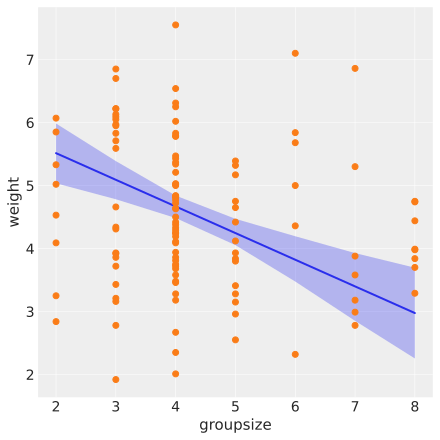

In [204]:
posterior_mu = jnp.expand_dims(post_samples_5h2['a'], -1) + \
                jnp.expand_dims(post_samples_5h2['bT'], -1) * foxes.area.mean() + \
                jnp.expand_dims(post_samples_5h2['bG'], -1)  * foxes.groupsize.values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(
    foxes.groupsize.values,
    foxes.weight.values,
    mean_mu,
    hpdi_mu
)
ax.set(xlabel='groupsize', ylabel='weight', title='')

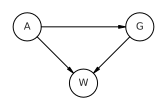

In [205]:
dag5h2 = CausalGraphicalModel(
    nodes=["W", "A", "G"],
    edges=[("A", "W"), ("G", "W"), ("A", "G")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "W": (1, 1), "G": (2, 0)}
for node in dag5h2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5h2.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

### 5h3

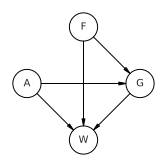

In [208]:
dag5h3 = CausalGraphicalModel(
    nodes=["W", "A", "G", "F"],
    edges=[("A", "W"), ("G", "W"), ("A", "G"), ("F", "G"), ("F", "W")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "W": (1, 1), "G": (2, 0), "F": (1,-1)}
for node in dag5h3.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5h3.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

In [210]:
def model_terr_food(food, territory):
    a = numpyro.sample('a', dist.Normal(4,0.5))
    bT = numpyro.sample("bT", dist.Normal(0, 5))
    mu = a + bT * territory
    sigma = numpyro.sample('sigma', dist.Uniform(0,5))
    numpyro.sample('food', dist.Normal(mu, sigma), obs=food)

kernel_terr_food = NUTS(model_terr_food)

mcmc_terr_food = MCMC(kernel_terr_food, num_warmup, num_samples)
mcmc_terr_food.run(rng_key_,
    territory=foxes.area.values,
    food=foxes.avgfood.values
)
mcmc_terr_food.print_summary()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 349.00it/s, 31 steps of size 1.73e-01. acc. prob=0.95]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.17      0.03      0.17      0.12      0.22    689.03      1.00
        bT      0.18      0.01      0.18      0.17      0.20    692.41      1.00
     sigma      0.09      0.01      0.09      0.08      0.10   1057.95      1.00

Number of divergences: 0


In [ ]:
mcmc_group_food = MCMC(kernel, num_warmup, num_samples)
mcmc_group_food.run(rng_key_,
    weight=foxes.weight.values,
    group=foxes.groupsize.values,
    food=foxes.avgfood.values
)
mcmc_group_food.print_summary()
post_samples_group_food = mcmc_group_food.get_samples()

In [207]:
mcmc_group_food_terr = MCMC(kernel, num_warmup, num_samples)
mcmc_group_food_terr.run(rng_key_,
    weight=foxes.weight.values,
    group=foxes.groupsize.values,
    territory=foxes.area.values,
    food=foxes.avgfood.values
)
mcmc_group_food_terr.print_summary()
post_samples_group_food_terr = mcmc_group_food_terr.get_samples()

sample: 100%|██████████| 3000/3000 [00:10<00:00, 295.75it/s, 31 steps of size 7.22e-02. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      4.06      0.33      4.05      3.47      4.57   1573.31      1.00
        bF      2.34      1.39      2.37      0.16      4.66   1025.19      1.00
        bG     -0.60      0.16     -0.60     -0.85     -0.34   1119.70      1.00
        bT      0.41      0.24      0.41     -0.01      0.79   1196.99      1.00
     sigma      1.14      0.08      1.13      1.00      1.25   1473.48      1.00

Number of divergences: 0


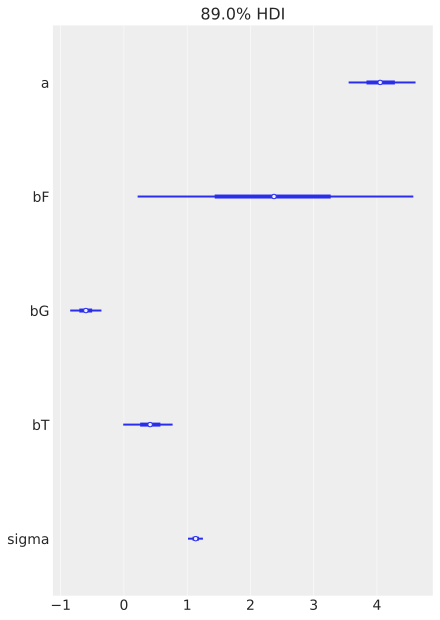

In [211]:
az.plot_forest(post_samples_group_food_terr, hdi_prob=0.89)
plt.show()